# Interpolation Calanus multivariate
Interpolate (multivariate) the observations of _Calanus finmarchicus_ and _Calanus helgolandicus_, using the water temperature as a co-variable.

The fields are prepared over a region covering the Northeast Atlantic.      
Different resolutions are tested: 0.5° X 0.5°, 1° X 1° and 2° X 2°.

In order to modify the directories, the spatial resolution, edit the configuration file [config.jl](../src/config.jl).

## Procedure

The steps are:
- reading the data
- preparting the land/sea mask
- setting the analysis parameters
- perform the interpolation

In [1]:
using Dates
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
const plt=PyPlot
using PyCall
include("../src/InterpCalanus.jl")
include("../src/config.jl")
@show pathof(DIVAnd)

[ Info: Workig at resoluton 0.25° X 0.25°
[ Info: Observation file already downloaded
[ Info: Bathymetry file already downloaded
[ Info: Temperature file already downloaded


pathof(DIVAnd) = "/home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd.jl"


"/home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd.jl"

## Files and directories
We need to have:
1. the temperature data
2. the CPR observations
3. the bathymetry.

The file `temperature_surface_WOD2.nc` contains all the temperature measurements in the region of interest and for a depth between 5 m and the sea surface. It was prepared with the notebook [`read_plot_WOD_data`](read_plot_WOD_data.ipynb).

## Domain, metrics, mask

In [62]:
longrid = domain[1]:dlon:domain[2]
latgrid = domain[3]:dlat:domain[4]
@info("Size of the grid: $(length(longrid)) X $(length(latgrid))")

_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

[ Info: Size of the grid: 130 X 104
[ Info: (130, 104)


### Mask

In [63]:
_, _, mask = DIVAnd.load_mask(bathyfile, true, longrid, latgrid, 5.0);

# Remove Med Sea
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

## Read the data
We will prepare monthly fields for given time periods.

In [64]:
yearmin = 2001
yearmax = 2001
imonth = 4

4

### Temperature

In [65]:
@time obsvalue, obslon, obslat, obsdepth, obstime, obsids = loadobs(Float64, temperaturefile, "Temperature");
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);
goodyear = (year_temperature .>= yearmin ) .& (year_temperature .<= yearmax) .& (month_temperature .== imonth)
@info("Found $(sum(goodyear)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

  0.225461 seconds (286.40 k allocations: 69.447 MiB)


[ Info: Found 1015 observations for the period April 2001 - 2001


In [66]:
@time lonT, latT, depthT, timeT, dataT = obslon[goodyear], obslat[goodyear], obsdepth[goodyear], 
obstime[goodyear], obsvalue[goodyear];

  0.000096 seconds (6 allocations: 40.359 KiB)


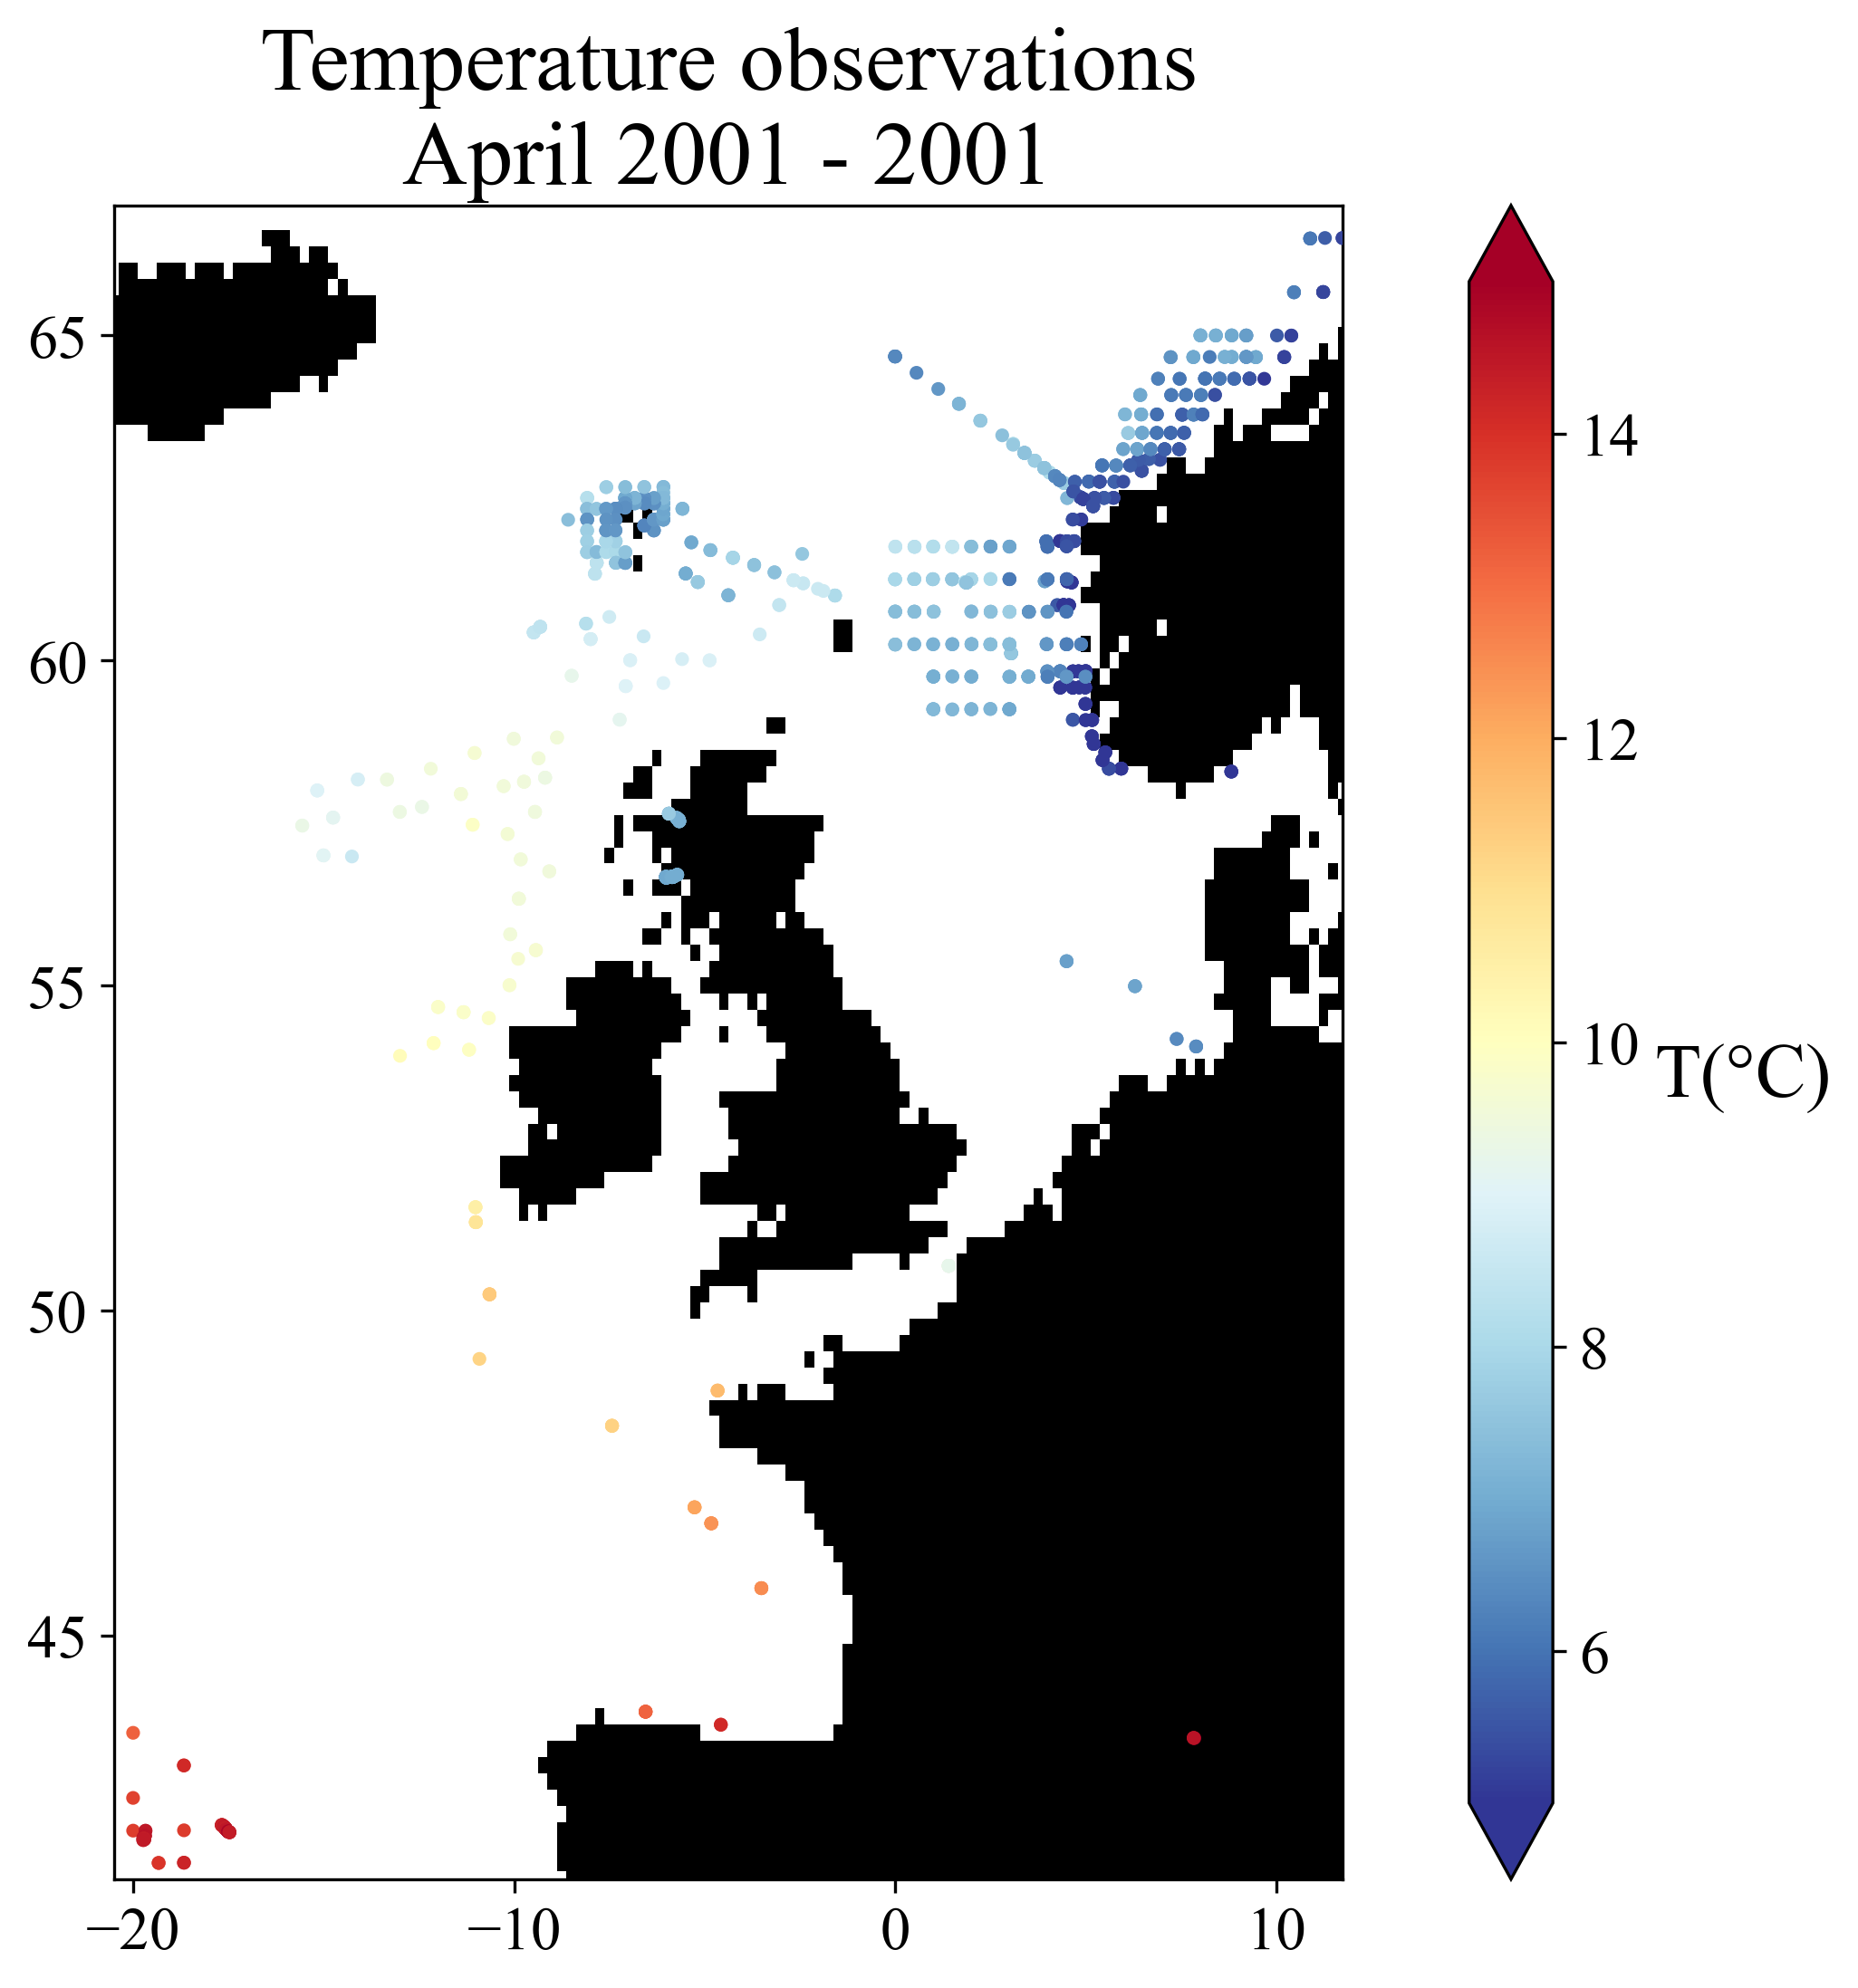

In [67]:
Tmin = 5.
Tmax = 15.

fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.scatter(lonT, latT, s=7, c=dataT, cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="both")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
cb.set_label("T(°C)", rotation=0, ha="left")
ax.set_title("Temperature observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "WOD_temperature_200104"))
plt.show()

### Plankton

In [68]:
@time lon, lat, dates, calanus_finmarchicus, calanus_helgolandicus = InterpCalanus.read_data_calanus(datafile);

  0.609859 seconds (4.82 M allocations: 147.833 MiB)


[ Info: (-20.447, 11.703)
[ Info: (41.2567, 66.808)


#### Subsetting

In [69]:
goodtimeCPR = (Dates.year.(dates) .>= yearmin ) .& (Dates.year.(dates) .<= yearmax) .& (Dates.month.(dates) .== imonth)
@info("Found plankton $(sum(goodtimeCPR)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

[ Info: Found plankton 261 observations for the period April 2001 - 2001


#### Make plot

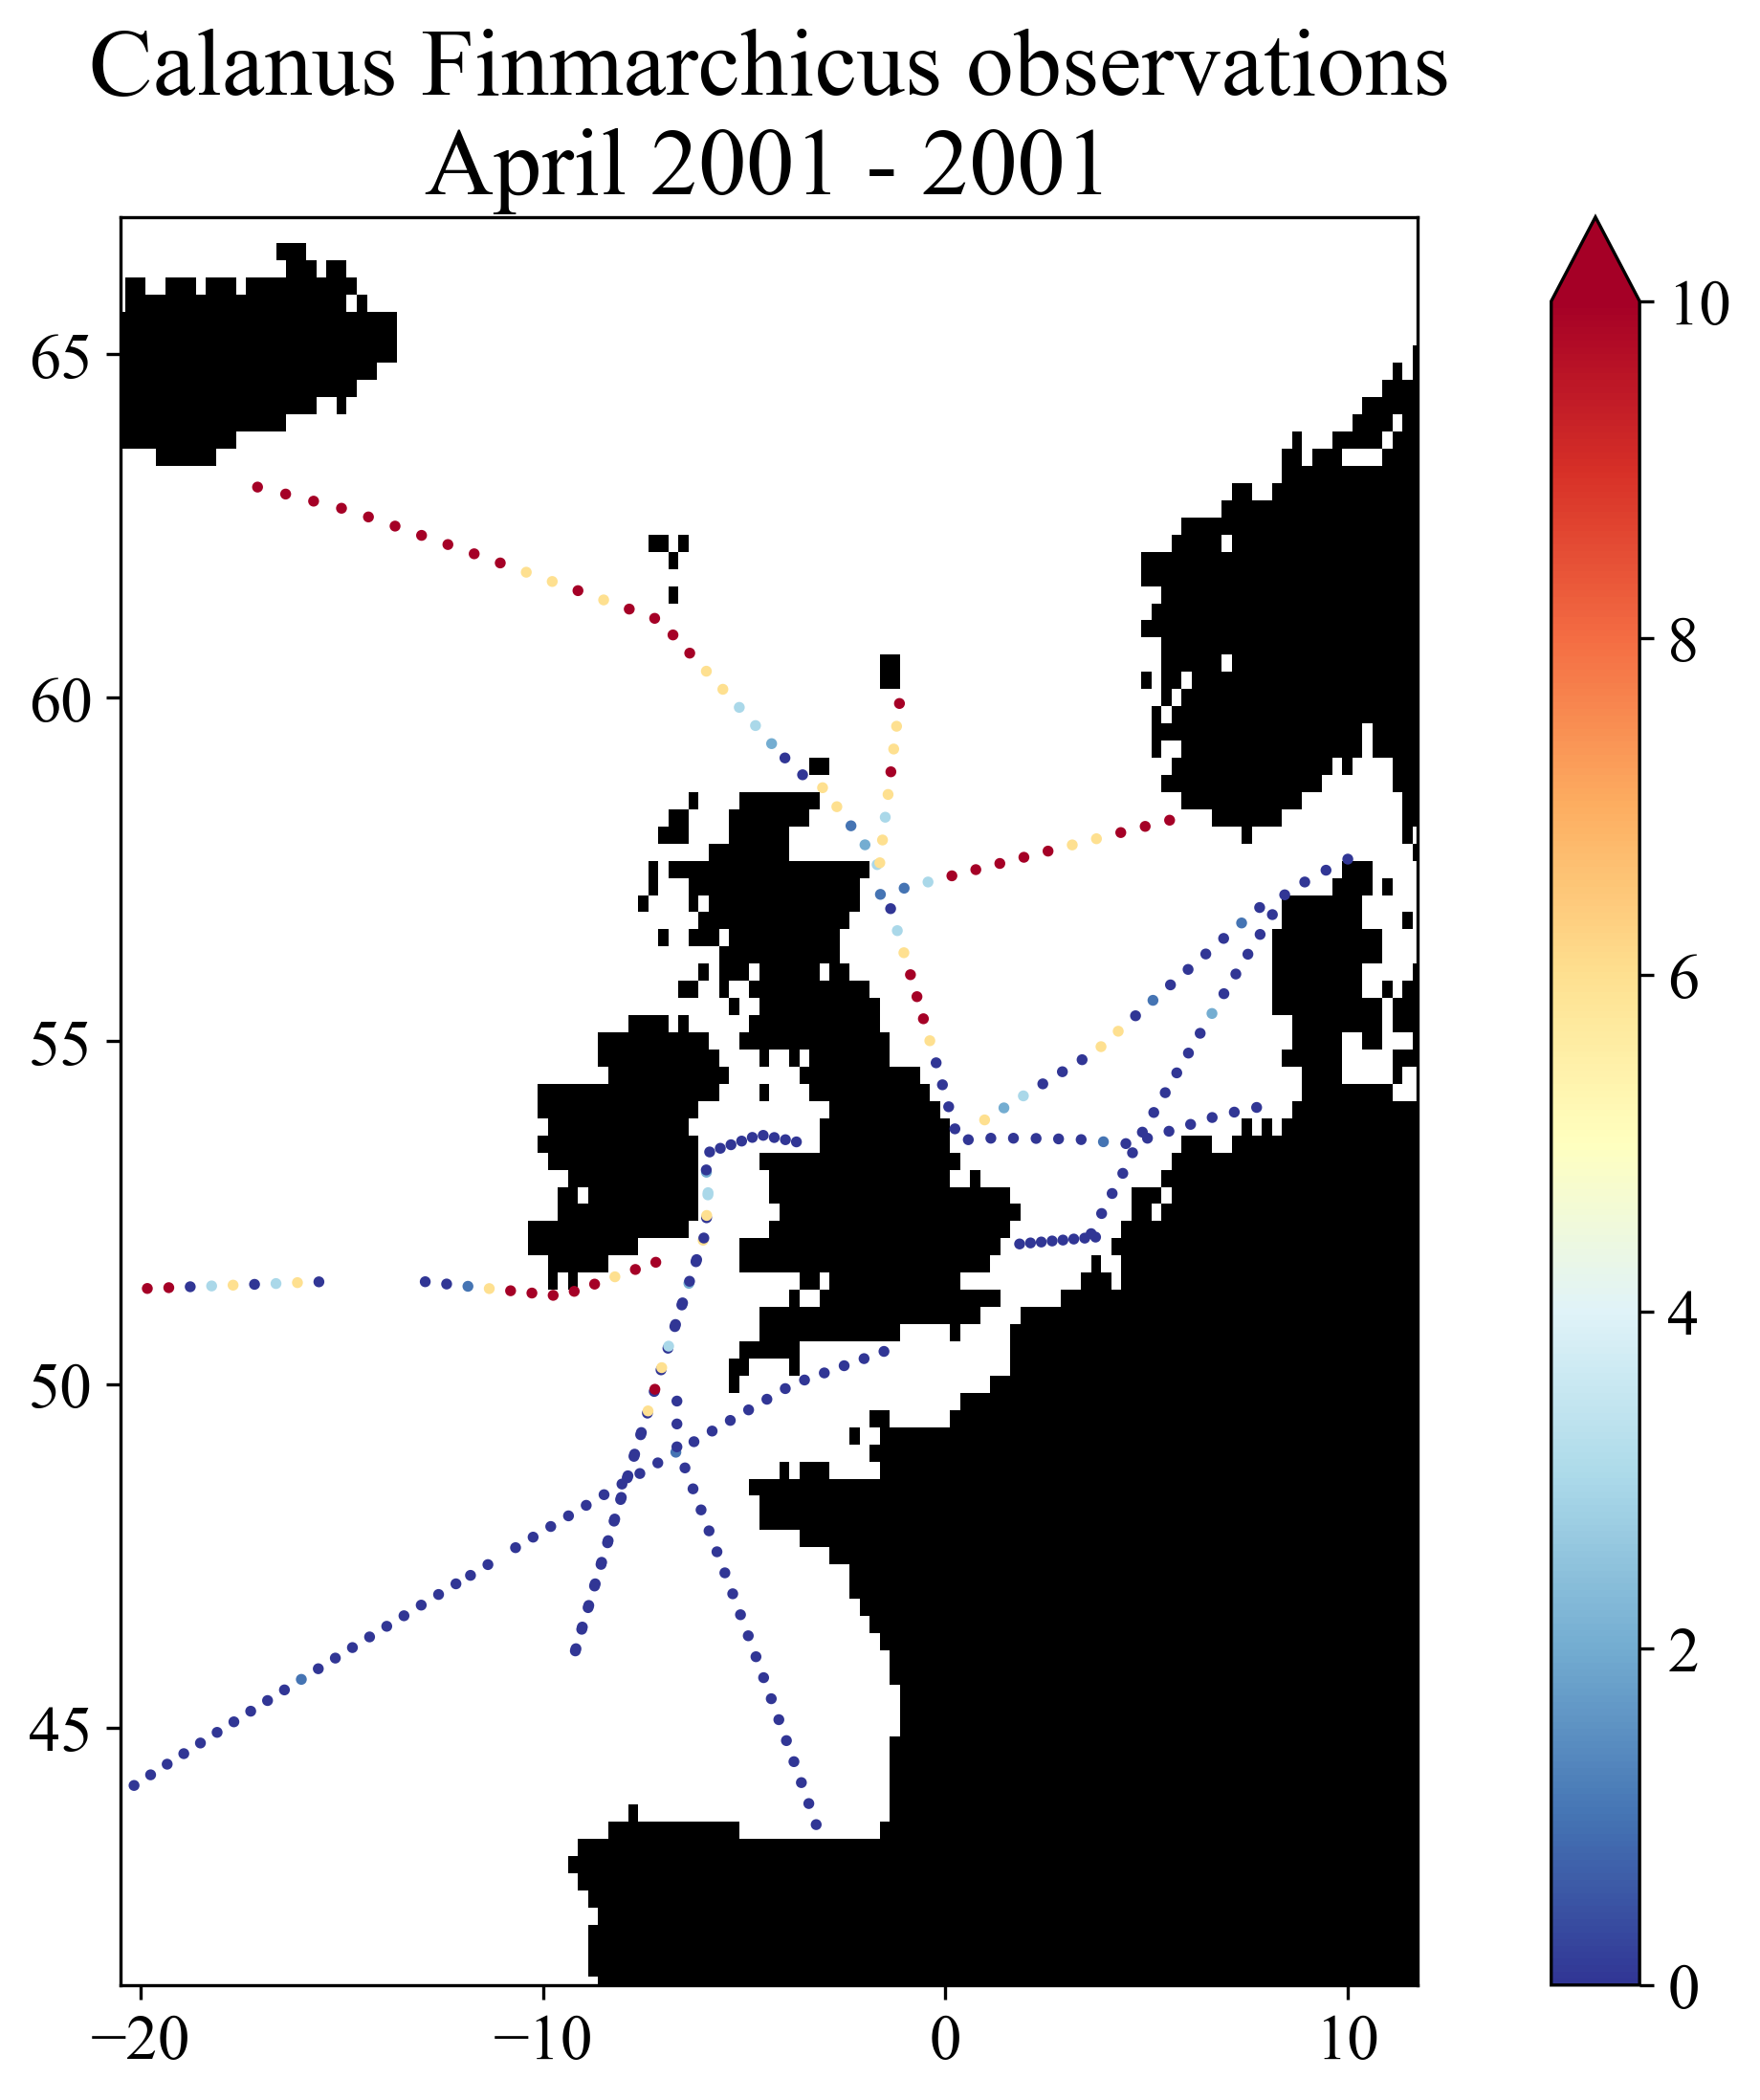

In [70]:
fig = plt.figure()
ax = plt.subplot(111)
pcm = ax.scatter(lon[goodtimeCPR], lat[goodtimeCPR], s=3, c=calanus_finmarchicus[goodtimeCPR], 
    cmap=plt.cm.RdYlBu_r, vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
ax.set_title("Calanus Finmarchicus observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "calanus_finmarchicus_200104"))
plt.show()

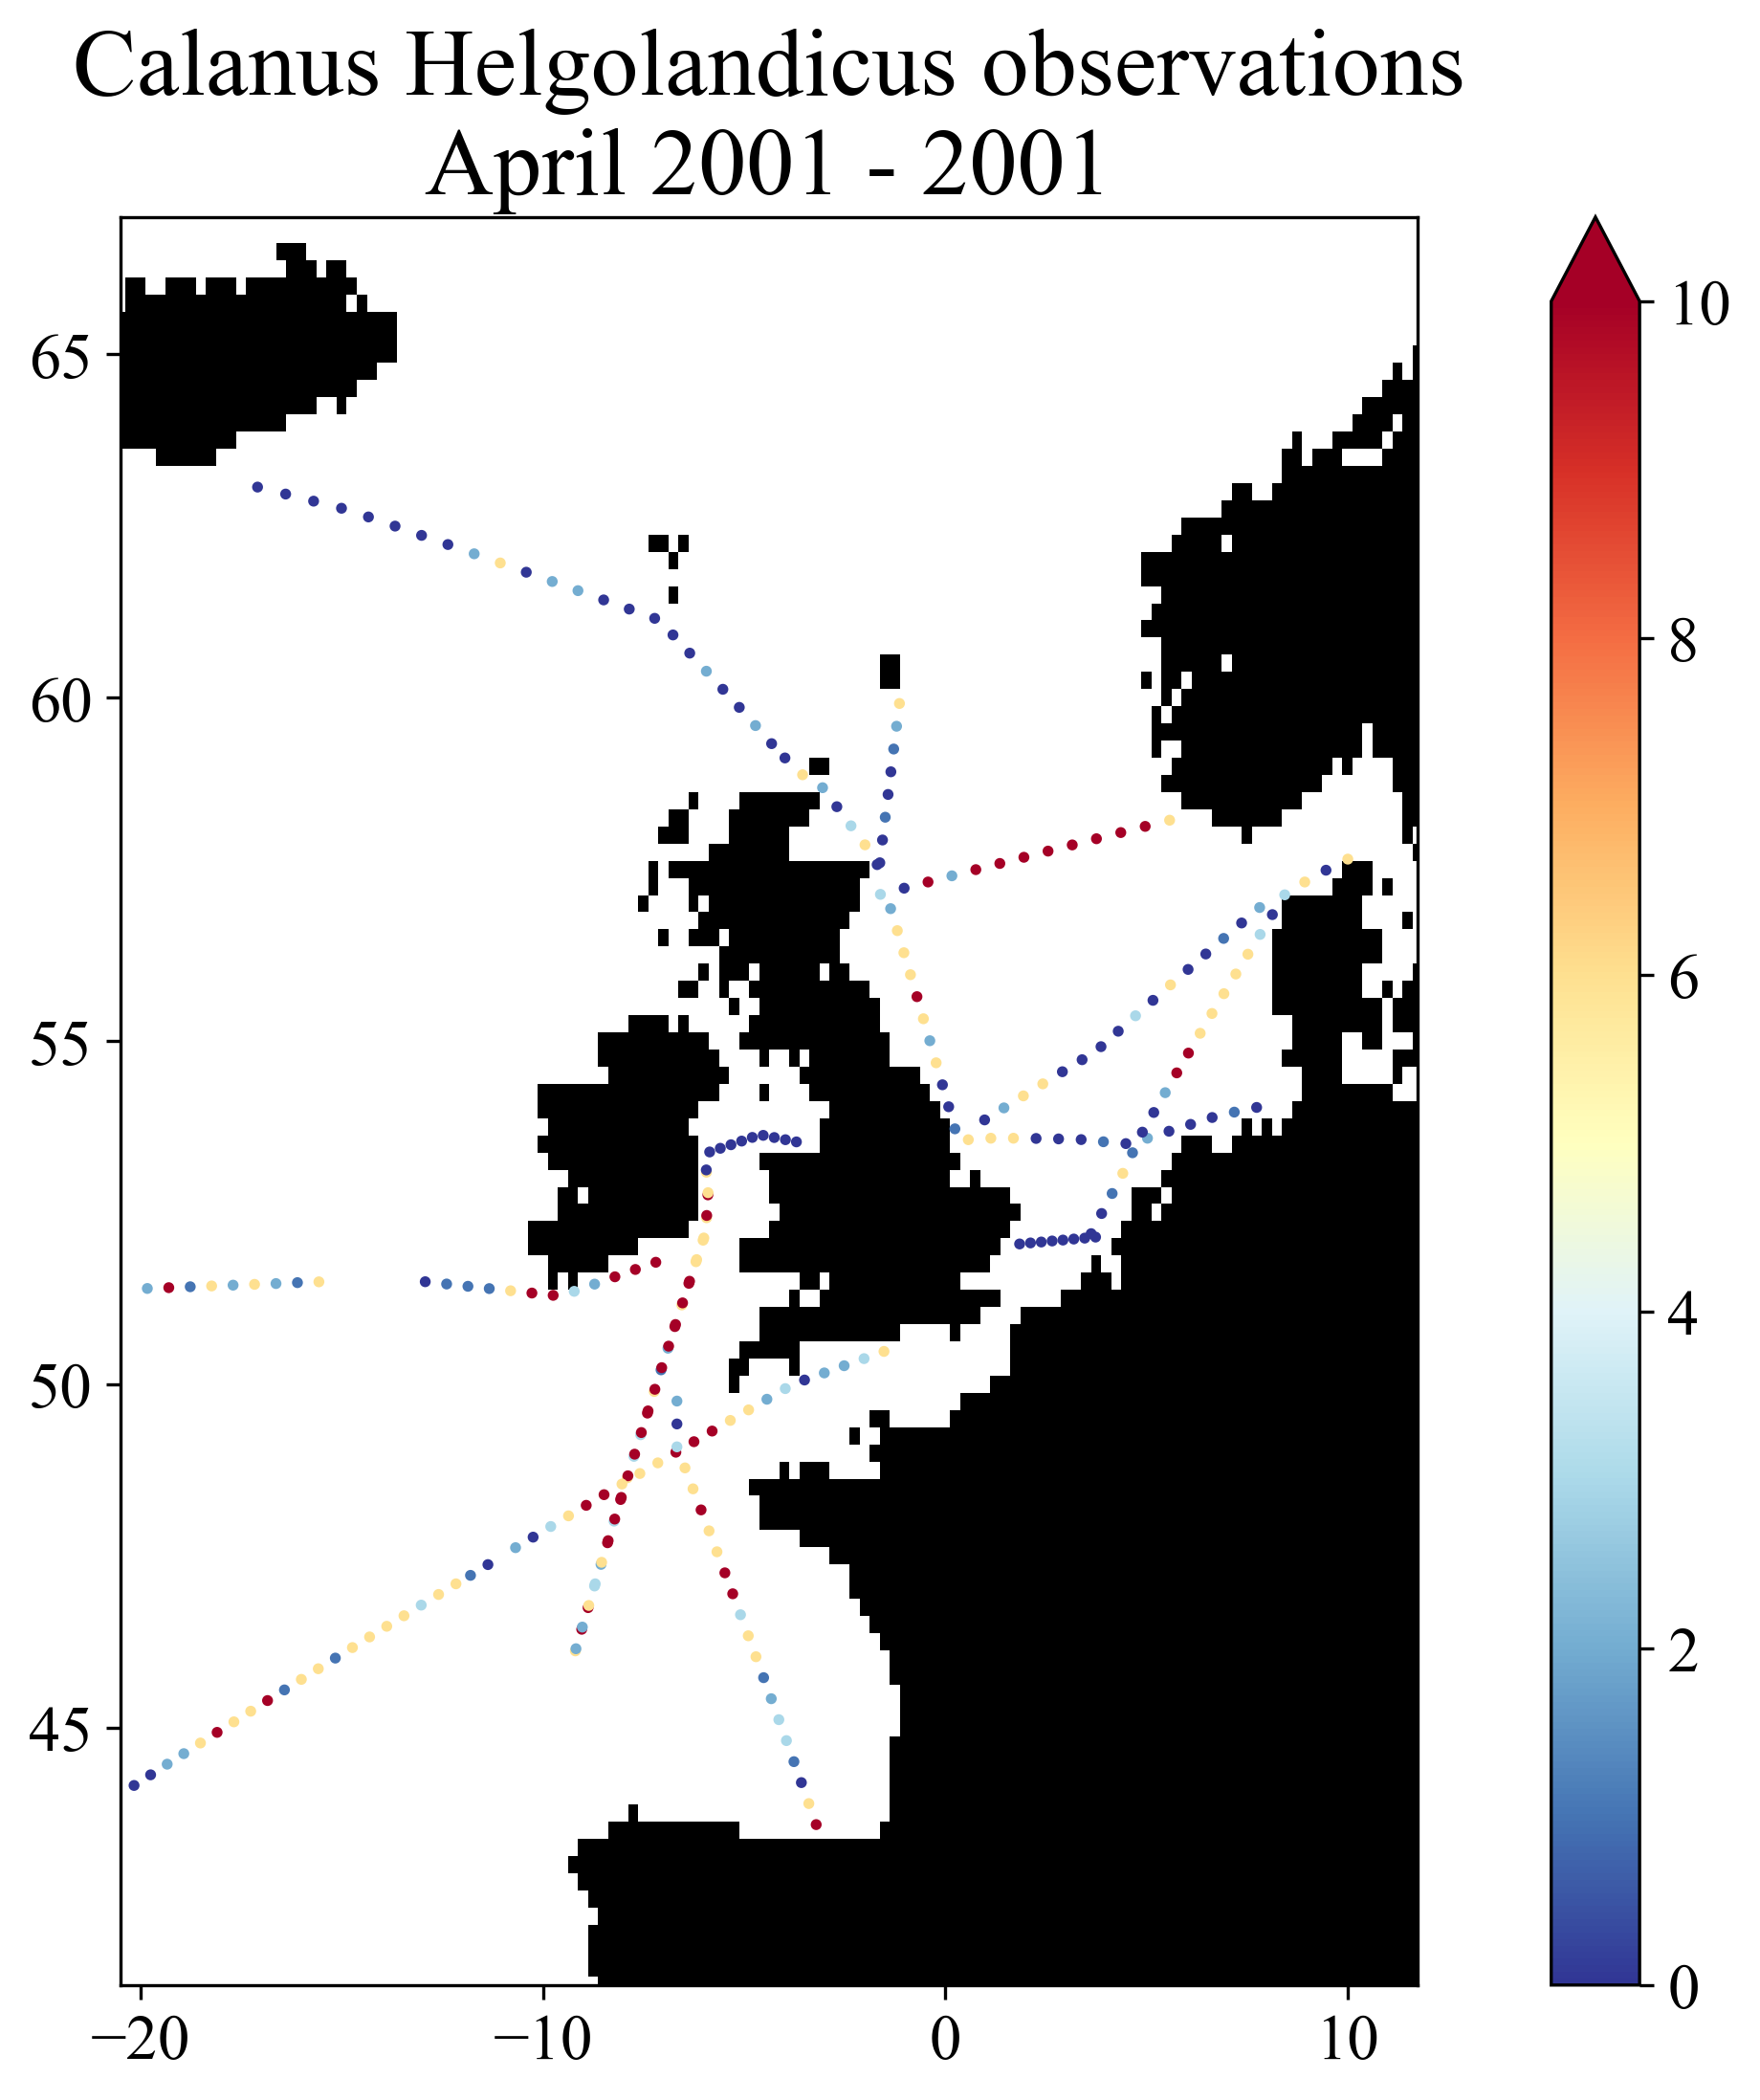

In [71]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon[goodtimeCPR], lat[goodtimeCPR], s=3, c=calanus_helgolandicus[goodtimeCPR], 
            cmap=plt.cm.RdYlBu_r, vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
ax.set_title("Calanus Helgolandicus observations\n$(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.savefig(joinpath(wodfigdir, "calanus_helgolandicus_200104"))
plt.show()

## Univariate analysis
### Parameters

In [72]:
L = 2.5
epsilon2 = 5.

5.0

### Monovariate

In [73]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtimeCPR], lat[goodtimeCPR]), 
    calanus_finmarchicus[goodtimeCPR] .- 0. * mean(calanus_finmarchicus[goodtimeCPR]), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodtimeCPR], lat[goodtimeCPR]), 
    calanus_helgolandicus[goodtimeCPR] .- 0. * mean(calanus_helgolandicus[goodtimeCPR]), (L, L), epsilon2);
@time T_interp, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lonT, latT), 
    dataT .- 1. * mean(dataT), (L, L), epsilon2);

  0.147122 seconds (6.14 k allocations: 118.596 MiB, 43.65% gc time)
  0.098504 seconds (6.14 k allocations: 118.596 MiB)
  0.179728 seconds (2.74 k allocations: 119.157 MiB, 37.40% gc time)


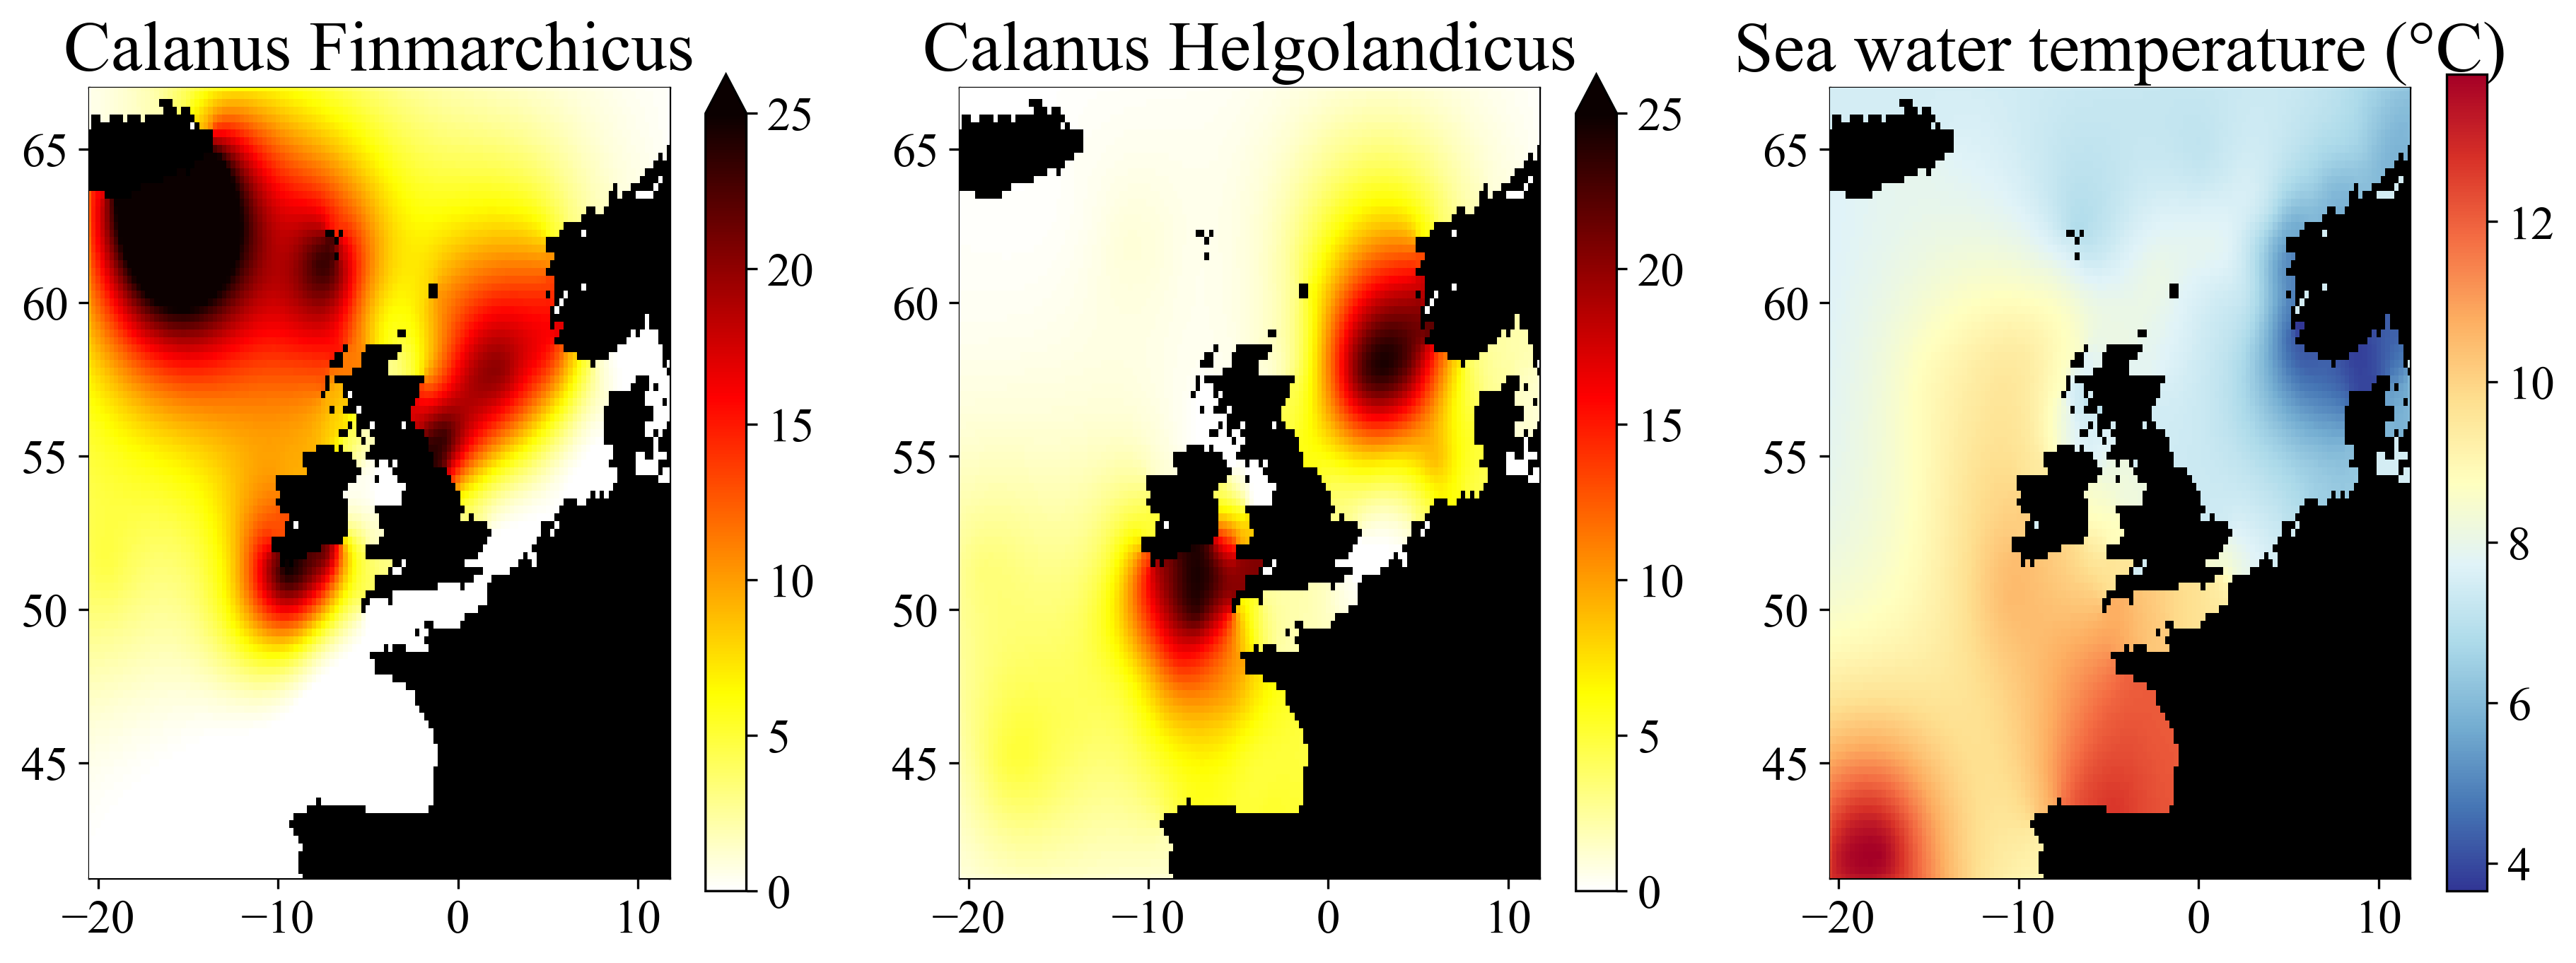

In [74]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi, yi, f_finmarchicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi, yi, f_helgolandicus, vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi, yi, T_interp .+ mean(dataT), cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)
ax.set_xlim(domain[1], domain[2])
ax.set_ylim(domain[3], domain[4])
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))
plt.savefig(joinpath(figdir, "monovariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

## Multivariate analysis
### Data preparation
1. Concatenate all the coordinate and observation vectors
2. Normalise the variables
3. Create a new dimension `vvv` with value **1** for plankton data points and **2** for temperature observations.

In [75]:
function normalise_obs(obs)
    obsmean = mean(obs)
    obsstd = std(obs)
    obsnorm = (obs .- obsmean) ./ obsstd
    return obsnorm, obsmean, obsstd
end

calanus_finmarchicus_norm, calanus_finmarchicus_mean, calanus_finmarchicus_std = 
normalise_obs(calanus_finmarchicus[goodtimeCPR]);

calanus_helgolandicus_norm, calanus_helgolandicus_mean, calanus_helgolandicus_std = 
normalise_obs(calanus_helgolandicus[goodtimeCPR])
 
T_norm, T_mean, T_std = normalise_obs(dataT);

In [76]:
lonmulti = vcat(lon[goodtimeCPR], lonT)
latmulti = vcat(lat[goodtimeCPR], latT)
obsmulti_finmarchicus = vcat(calanus_finmarchicus_norm, T_norm)
obsmulti_helgolandicus = vcat(calanus_helgolandicus_norm, T_norm)
vvv = vcat(ones(length(findall(goodtimeCPR))), 2 * ones(length(lonT)));

### Create metrics and mask

In [77]:
maskmulti, (pm, pn, pv), (xi, yi, vi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid, 1:2);
maskmulti[:,:,1] = mask;
maskmulti[:,:,2] = mask;

### Perform analysis

In [78]:
@time fi1,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvvint), obsmulti_finmarchicus, 
    (L, L, 0.0), epsilon2);

@time fi2,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvvint), obsmulti_helgolandicus, 
    (L, L, 0.0), epsilon2);

  0.245380 seconds (26.93 k allocations: 287.439 MiB, 12.83% gc time)
  0.343695 seconds (26.93 k allocations: 287.439 MiB, 33.79% gc time)


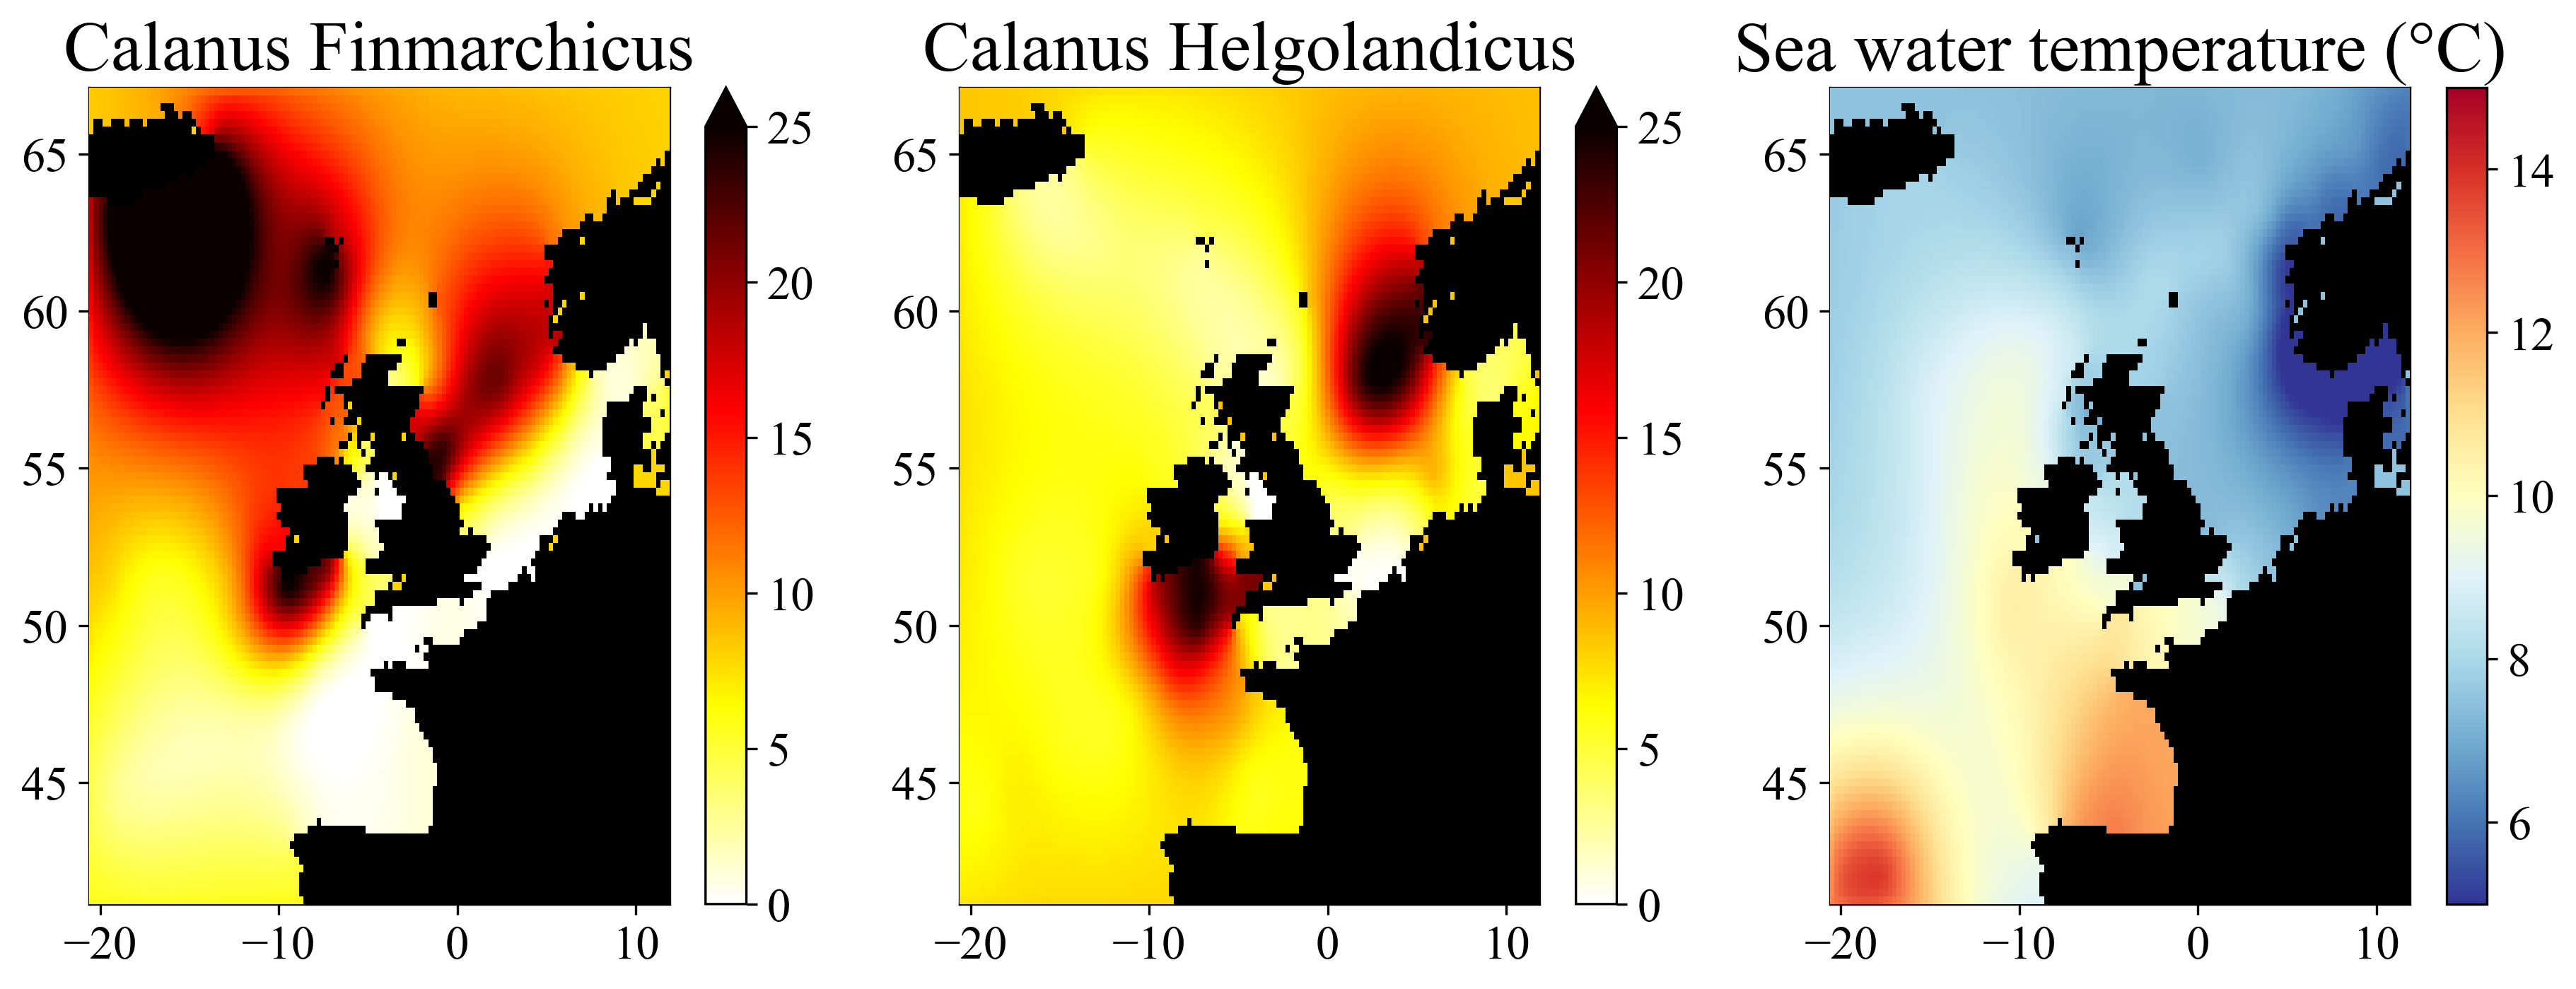

In [79]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fi1[:,:,1] .* calanus_finmarchicus_std) .+ calanus_finmarchicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fi2[:,:,1] .* calanus_helgolandicus_std) .+ calanus_helgolandicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1],
    (fi2[:,:,2] .* T_std) .+ T_mean, 
    cmap=plt.cm.RdYlBu_r, zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "multivariate01.png"), dpi=300, bbox_inches="tight")
plt.show()

## Multivariate analysis
### EOF approach

In [82]:
@time fim1, s1, eof1, eofamplitudes1, emap1, emapm1 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 .*L), epsilon2);

 29.530688 seconds (50.19 M allocations: 3.180 GiB, 6.00% gc time, 97.97% compilation time)


┌ Warning: Sorry not reliable to infer correlations
└ @ DIVAnd ~/ULiege/Tools/DIVAnd.jl/src/DIVAnd_multivarEOF.jl:147


In [84]:
@time fim2, s2, eof2, eofamplitudes2, emap2, emapm2 = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 .*L), epsilon2);

  0.368573 seconds (54.21 k allocations: 585.138 MiB, 3.89% gc time)


┌ Warning: Sorry not reliable to infer correlations
└ @ DIVAnd ~/ULiege/Tools/DIVAnd.jl/src/DIVAnd_multivarEOF.jl:147


#### Plot the gridded fields

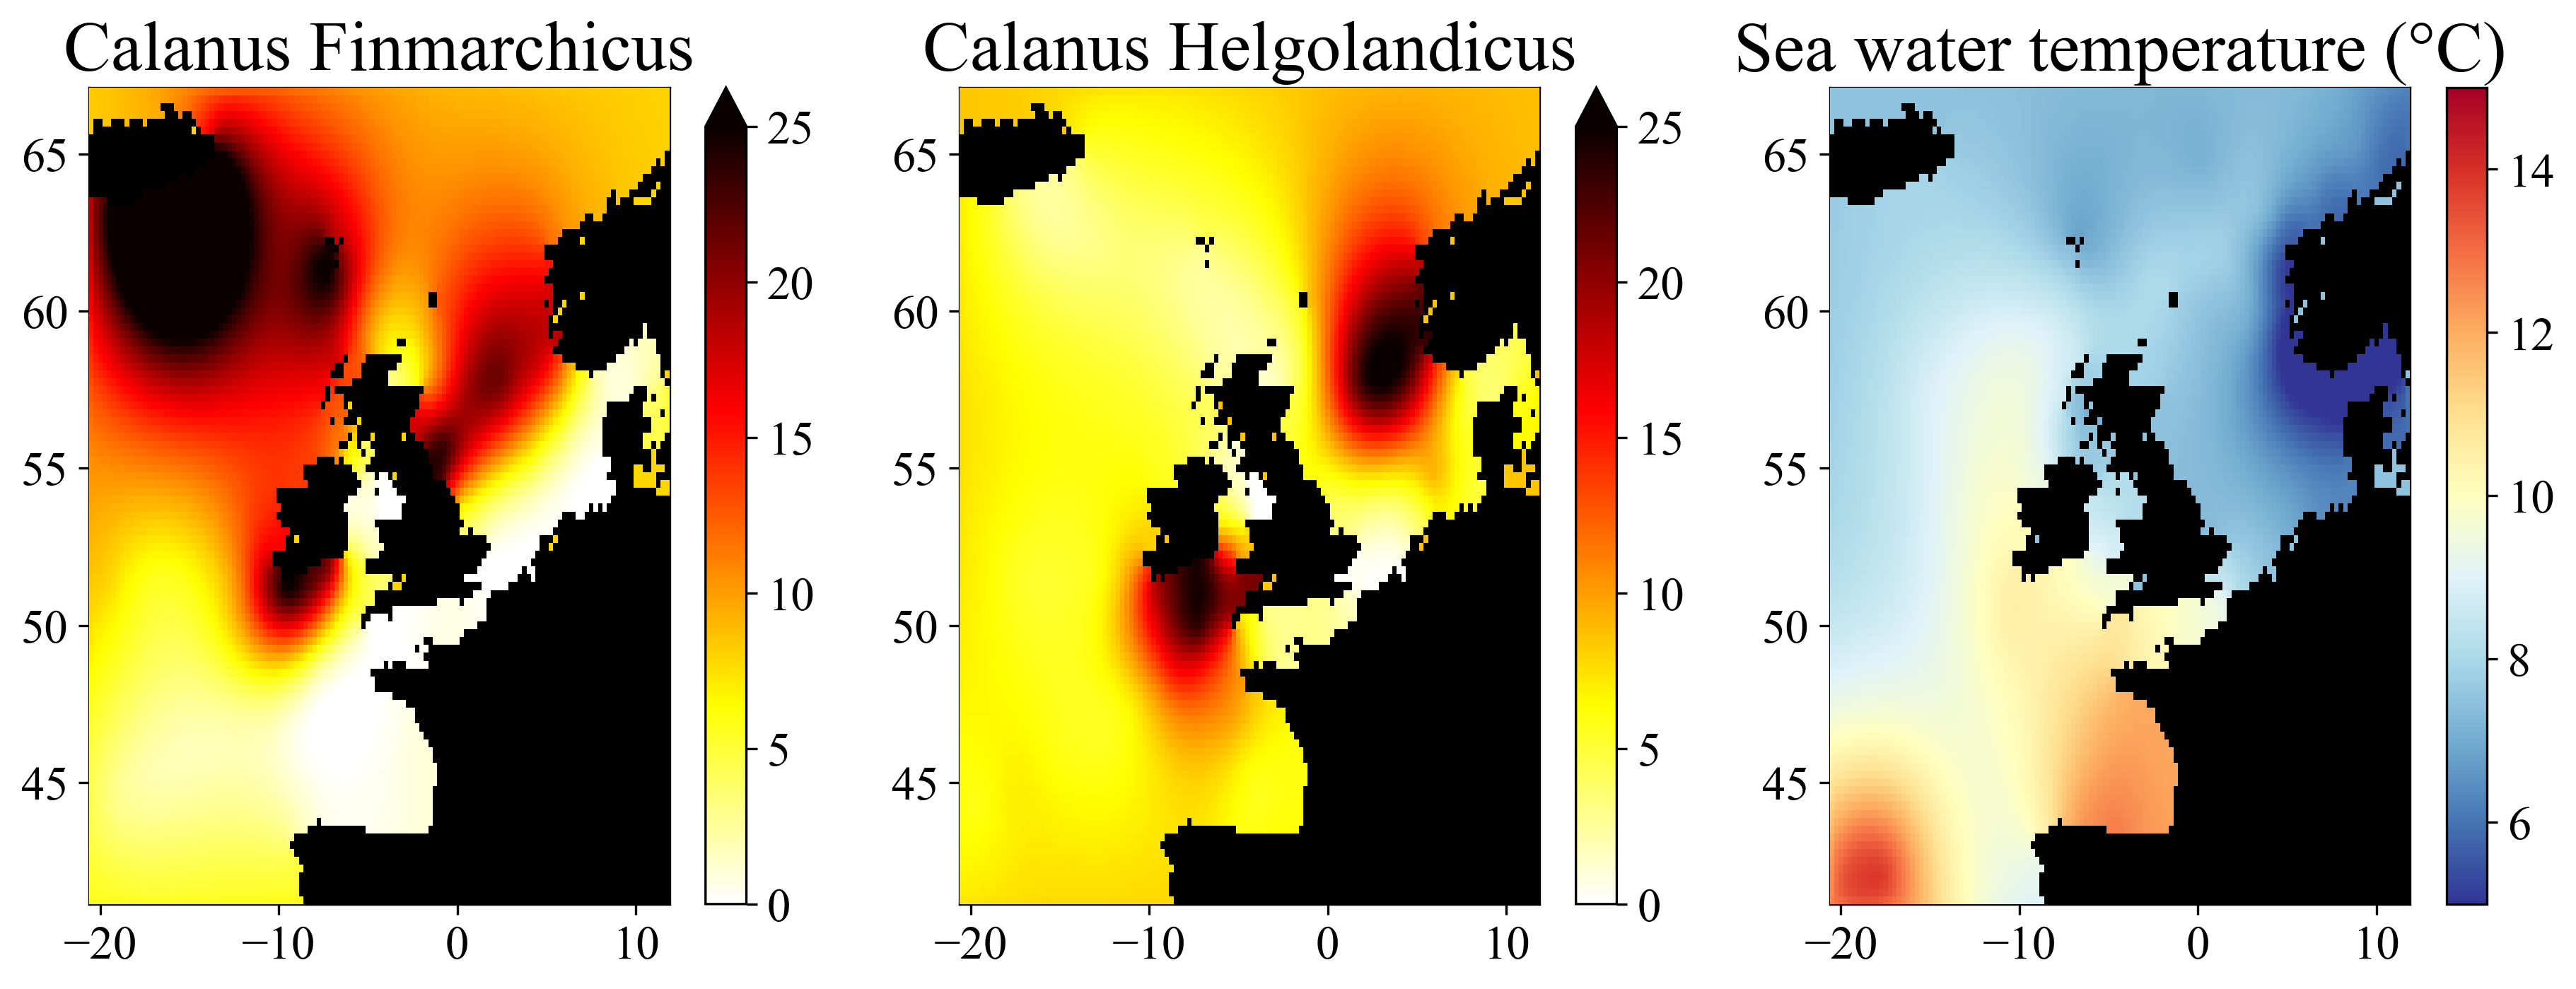

In [85]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1[:,:,1] .* calanus_finmarchicus_std) .+ calanus_finmarchicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2[:,:,1] .* calanus_helgolandicus_std) .+ calanus_helgolandicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1[:,:,2] .* T_std) .+ T_mean, cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)
plt.savefig(joinpath(figdir, "multivariate_eof.png"), dpi=300, bbox_inches="tight")

plt.show()

### Jacobian approach

In [86]:
@time fim1Jac, s1, emap1, emapm1, pv1 = DIVAnd_multivarJAC(maskmulti, 
    (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar scpme"
methm = :scpme
 15.542609 seconds (23.11 M allocations: 3.951 GiB, 3.65% gc time, 83.48% compilation time)


In [87]:
@time fim2Jac, s2, emap2, emapm2, pv2 = DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), 
    (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 * L), epsilon2; epsilon2jacobian=(1.0,10.));

eps2jac = (1.0, 10.0)
"error method in multivar $(meth)" = "error method in multivar scpme"
methm = :scpme
  2.149487 seconds (1.37 M allocations: 2.808 GiB, 3.54% gc time)


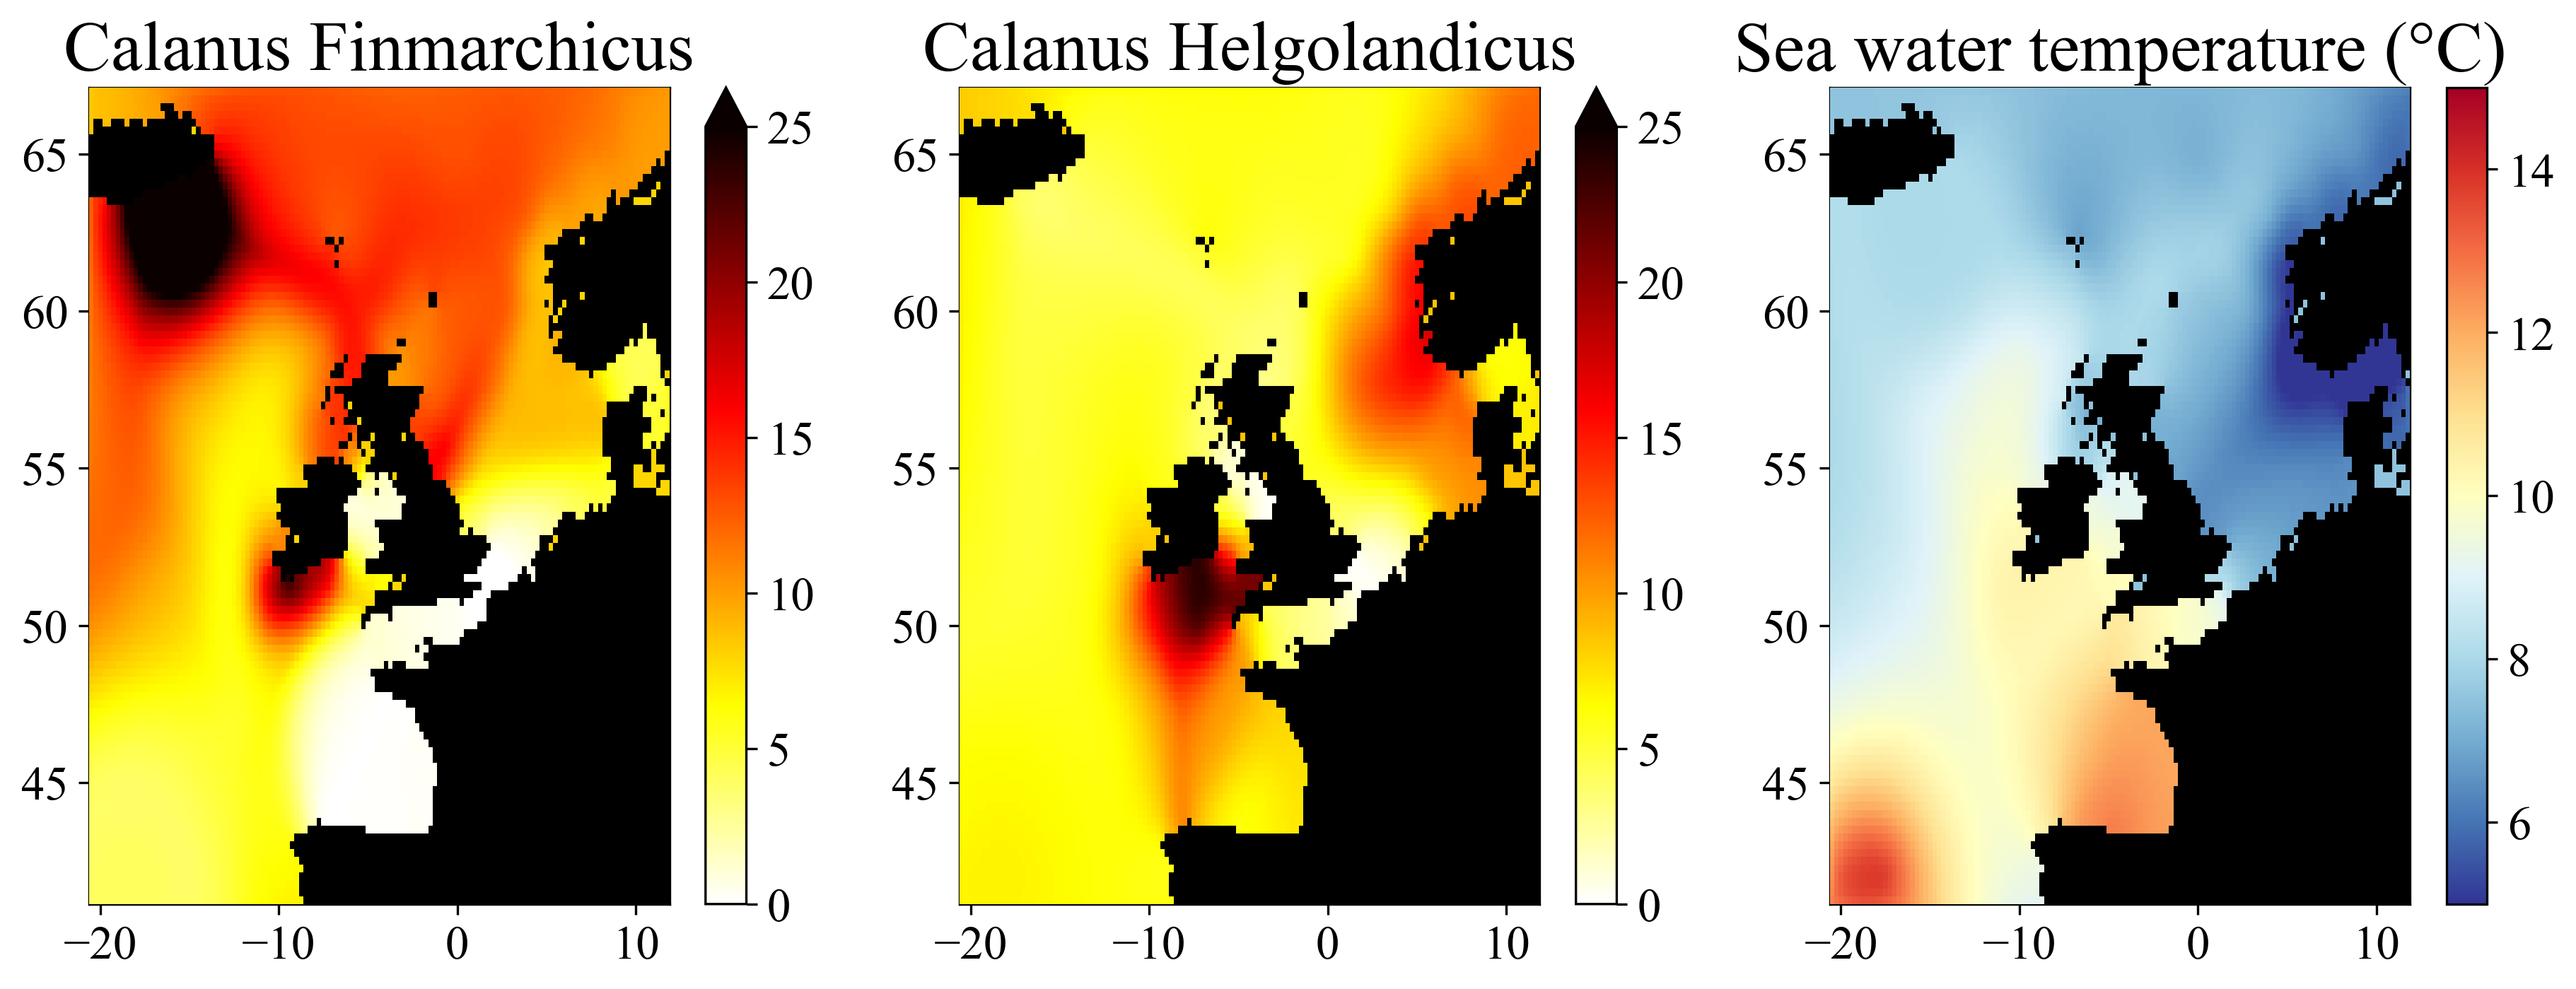

In [88]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim1Jac[:,:,1] .* calanus_finmarchicus_std) .+ calanus_finmarchicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], 
    (fim2Jac[:,:,1] .* calanus_helgolandicus_std) .+ calanus_helgolandicus_mean, 
    vmin=0, vmax=25., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], (fim1Jac[:,:,2] .* T_std) .+ T_mean, 
    cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=Tmin, vmax=Tmax)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)

plt.savefig(joinpath(figdir, "multivariate_jac.png"), dpi=300, bbox_inches="tight")


plt.show()

In [89]:
figdir

"../figures/multivariate/"